# Acoustic wavefield separation - Volve data

### Author: M.Ravasi

This notebook applies multi-component wavefield separation to the Volve data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops

from scipy.signal import butter, lfilter, freqz
from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

In [2]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# ST10

We can now download the file of interest following a similar approach to that explained in ``SeismicInversion-Volve`` notebook

In [3]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name dataplatformblvolve --container-name pub --name Seismic/ST10010/Raw_data/ST10010+NAV_MERGE/ST10010_1150780_40203.sgy --file ST10010_1150780_40203.sgy --sas-token "$YOURTOKEN"

### Data inspection

Let's import input data from file

In [4]:
inputfile = '../data/updown/ST10010_1150780_40203.sgy'
f = segyio.open(inputfile, ignore_geometry=True)

In [5]:
print(segyio.tools.wrap(f.text[0]))    

bytearray(b'C 1 CLIENT: STATOIL           COMPANY: RESERVOIR EXPLORATION
TECHNOLOGY         C 2 AREA: VOLVE NORWAY BLOCK 15/9                SURVEY:
ST10010                C 3 SWATH:  11                             VESSELS:M/V
VIKLAND, M/V SANCO SPIRITC 4 RCV LINE: 1150780    RCVR RANGE: 1239-1717
C 5 DATA-SET: NAV MERGE   TRACES PER RECORD: 240 X 4   SEQ: 094-133
C 6 RECORDING FORMAT: IEEE SEG-Y           FORMAT THIS REEL: SEG-Y 3592
C 7 SAMPLE CODE: FLOATING PT               PROCESSED: 03/11/2010
C 8 ACQ. GEOM: 8 ROLL 8  INLINE SWATH      LINE PREFIX: ST10010
C 9 INSTRUMENT: VECTORSEIS OCEAN BOTTOM    RECORDING SYSTEM DELAY: 0 MS
C10 RECORDING FILTER: 1.5/6-187/260MIN PHS DESCRIPTION: HZ/DB PER OCTAVE
C11 NO OF RECEIVER LINES/SWATH: 8          RECEIVER LINE SEPARATION: 400/200M
C12 ACTIVE CABLE LENGTH: 5975M             RCVRS / RCV LINE 240 X 4
C13 NO OF SOURCES:  2                      SOURCE SEPARATION: 50M
C14 RECEIVER INTERVAL: 25M                 SHOT INTERVAL: 25M, FLIP/FLOP
C1

In [6]:
# number of traces per shot (effectively they are / 4 as for each rec there is P, VZ, VX, VY)
ntraces_per_shot = f.bin[segyio.binfield.BinField.Traces]
ntraces = f.tracecount
nshots = ntraces // ntraces_per_shot
nr = ntraces_per_shot // 4

print(ntraces, ntraces_per_shot, nshots)

9212160 960 9596


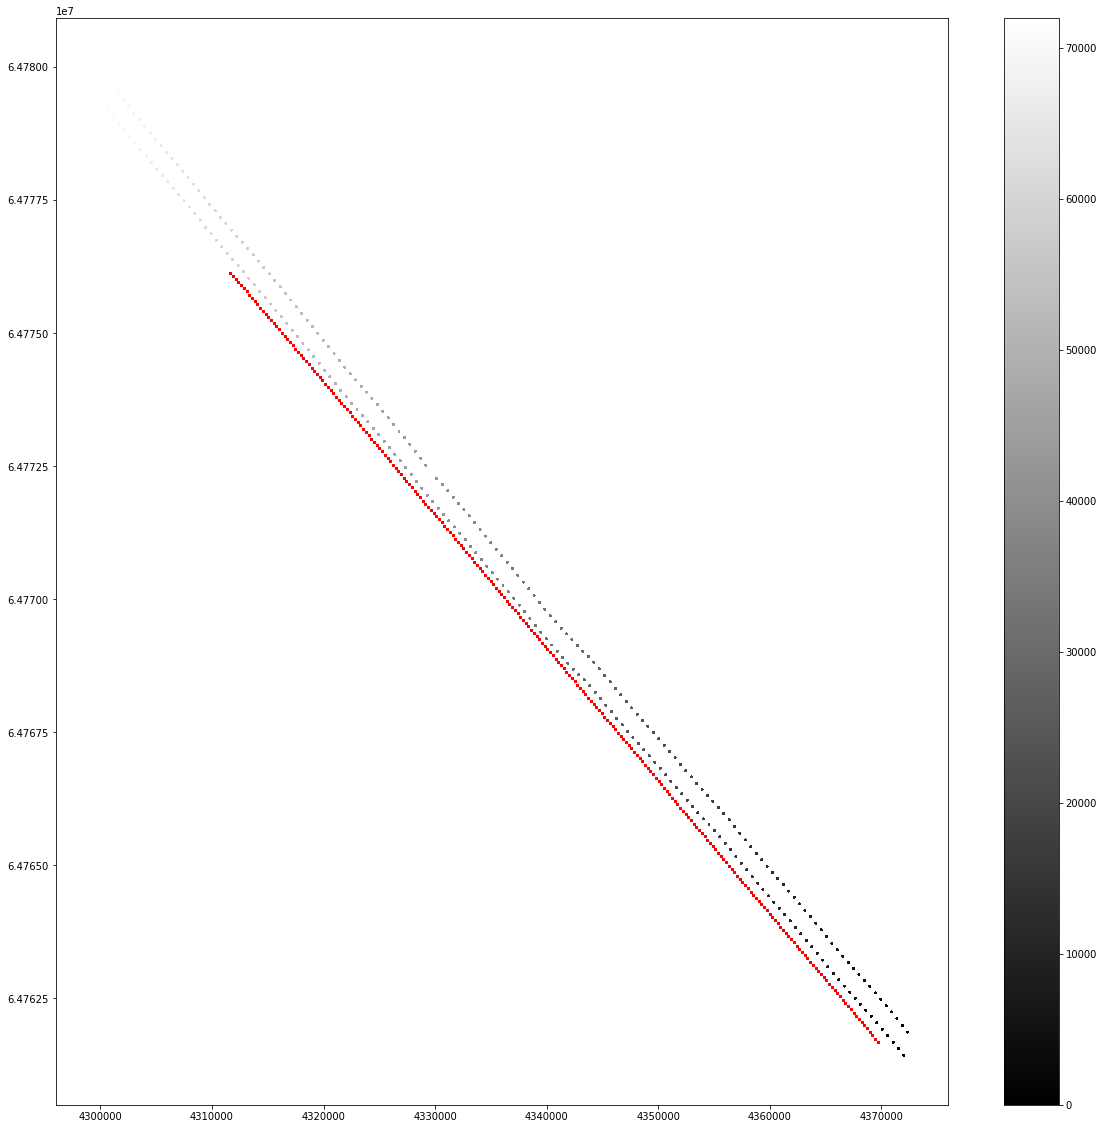

In [25]:
startshot=4900
endshot=5200
jshot=4 # not to get all components

src_x = f.attributes(segyio.TraceField.SourceX)[startshot*ntraces_per_shot:endshot*ntraces_per_shot:jshot]
src_y = f.attributes(segyio.TraceField.SourceY)[startshot*ntraces_per_shot:endshot*ntraces_per_shot:jshot]

rec_x = f.attributes(segyio.TraceField.GroupX)[startshot*ntraces_per_shot:endshot*ntraces_per_shot:jshot]
rec_y = f.attributes(segyio.TraceField.GroupY)[startshot*ntraces_per_shot:endshot*ntraces_per_shot:jshot]

plt.figure(figsize=(20, 20))
im = plt.scatter(src_x, src_y, c=np.arange(len(src_x)), s=1, cmap='gray')
plt.scatter(rec_x, rec_y, color='r', s=1)
plt.colorbar(im);

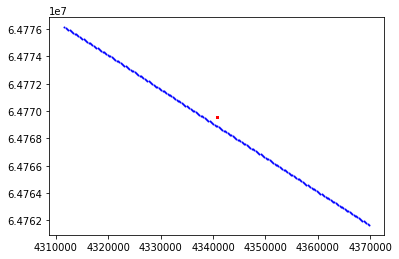

In [8]:
shot=5030
jshot=4 # not to get all components

src_x = f.attributes(segyio.TraceField.SourceX)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]
src_y = f.attributes(segyio.TraceField.SourceY)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]
src_z = f.attributes(segyio.TraceField.SourceDepth)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]

rec_x = f.attributes(segyio.TraceField.GroupX)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]
rec_y = f.attributes(segyio.TraceField.GroupY)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]
rec_z = f.attributes(segyio.TraceField.GroupWaterDepth)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]

plt.figure()
plt.scatter(src_x, src_y, color='r', s=1)
plt.scatter(rec_x, rec_y, color='b', s=1);

In [9]:
vwater = 1480.

offset = np.sqrt((src_x[0]/10. - rec_x/10.) ** 2 + (src_y[0]/10. - rec_y/10.) ** 2)
distance = np.sqrt((src_z[0]/10. - rec_z/10.) ** 2 + (src_x[0]/10. - rec_x/10.) ** 2 + (src_y[0]/10. - rec_y/10.) ** 2)
tdir = distance / vwater

offsetreg = np.linspace(-offset[0], offset[-1], nr)

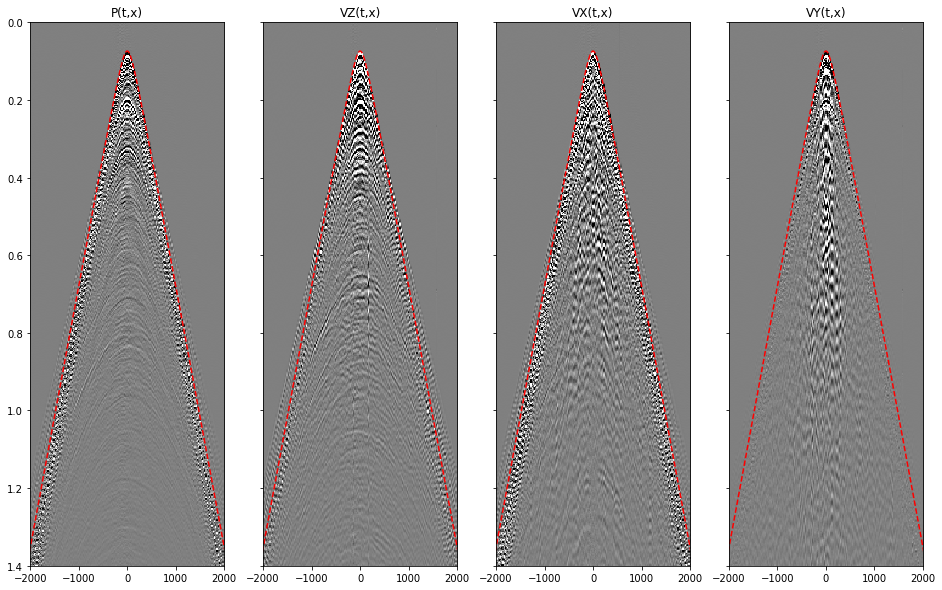

In [10]:
t = f.samples / 1000.
dt = t[1]-t[0]

d = segyio.collect(f.trace[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot])
p = d[::4]
vz = d[1::4]
vx = d[2::4]
vy = d[3::4]

# Apply derivative also to VZ to compensate for hydrophone derivative
#vz = np.hstack((np.diff(vz, axis=1), np.zeros((nr, 1))))

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 10))
axs[0].imshow(p.T, cmap='gray', vmin=-5e6, vmax=5e6,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].plot(offsetreg, tdir, '--r')
axs[0].set_title('P(t,x)')
axs[0].axis('tight');
axs[1].imshow(vz.T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].plot(offsetreg, tdir, '--r')
axs[1].set_title('VZ(t,x)')
axs[1].axis('tight');
axs[1].set_ylim(4, 0);
axs[2].imshow(vx.T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[2].plot(offsetreg, tdir, '--r')
axs[2].set_title('VX(t,x)')
axs[2].axis('tight');
axs[2].set_ylim(4, 0);
axs[3].imshow(vy.T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[3].plot(offsetreg, tdir, '--r')
axs[3].set_title('VY(t,x)')
axs[3].axis('tight');
axs[3].set_ylim(1.4, 0);
axs[3].set_xlim(-2000, 2000);

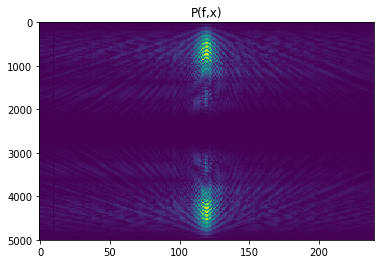

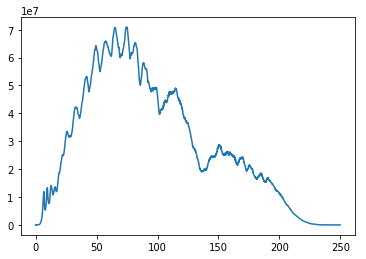

In [11]:
nfft = p.shape[1]
freq = np.fft.fftfreq(nfft, dt)
P = np.fft.fft(p, n=nfft, axis=-1)

plt.figure()
plt.imshow(np.abs(P).T)
plt.title('P(f,x)')
plt.axis('tight')

plt.figure()
plt.plot(freq[:nfft//2], np.mean(np.abs(P), axis=0)[:nfft//2])

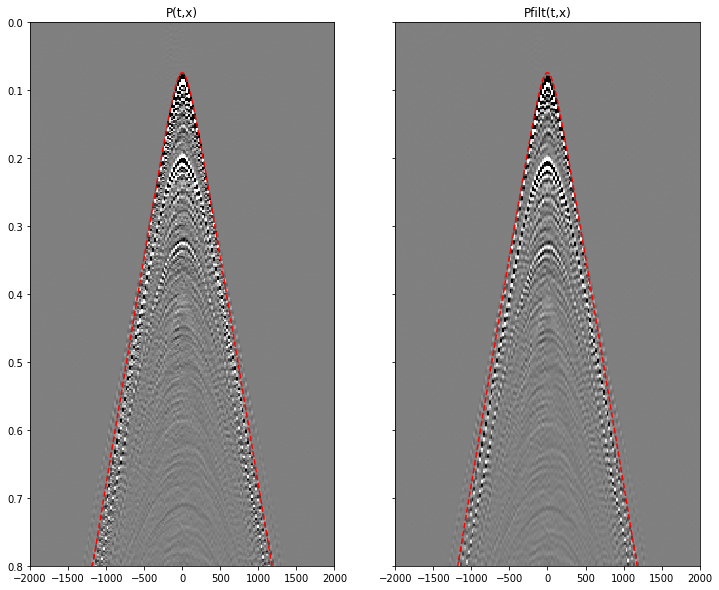

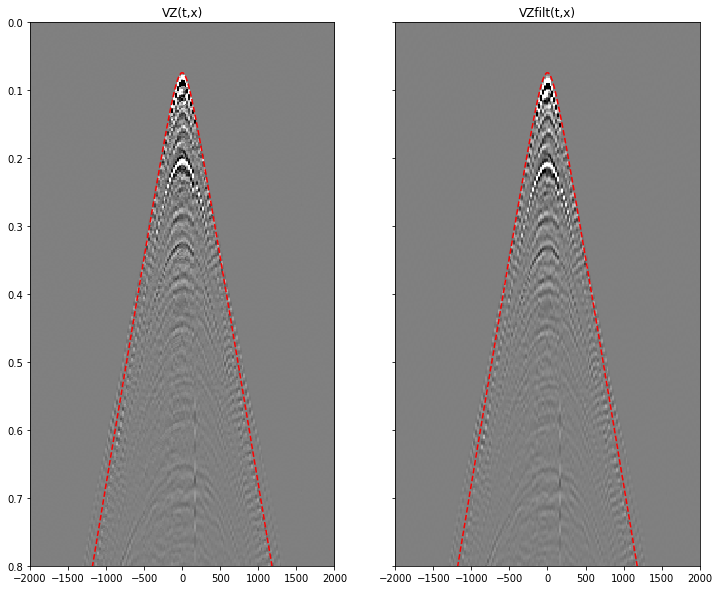

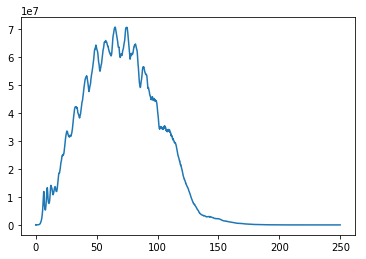

In [12]:
pfilt = butter_lowpass_filter(p, 110., 1/dt, 5)
Pfilt = np.fft.fft(pfilt, n=nfft, axis=-1)

vzfilt = butter_lowpass_filter(vz, 110., 1/dt, 5)
VZfilt = np.fft.fft(vzfilt, n=nfft, axis=-1)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 10))
axs[0].imshow(p.T, cmap='gray', vmin=-1e7, vmax=1e7,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].plot(offsetreg, tdir, '--r')
axs[0].set_title('P(t,x)')
axs[0].axis('tight');
axs[1].imshow(pfilt.T, cmap='gray', vmin=-1e7, vmax=1e7,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].plot(offsetreg, tdir, '--r')
axs[1].set_title('Pfilt(t,x)')
axs[1].axis('tight');
axs[1].set_ylim(.8, 0)
axs[1].set_xlim(-2000, 2000)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 10))
axs[0].imshow(vz.T, cmap='gray', vmin=-5e5, vmax=5e5,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].plot(offsetreg, tdir, '--r')
axs[0].set_title('VZ(t,x)')
axs[0].axis('tight');
axs[1].imshow(vzfilt.T, cmap='gray', vmin=-5e5, vmax=5e5,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].plot(offsetreg, tdir, '--r')
axs[1].set_title('VZfilt(t,x)')
axs[1].axis('tight');
axs[1].set_ylim(.8, 0)
axs[1].set_xlim(-2000, 2000)

plt.figure()
plt.plot(freq[:nfft//2], np.mean(np.abs(Pfilt), axis=0)[:nfft//2]);

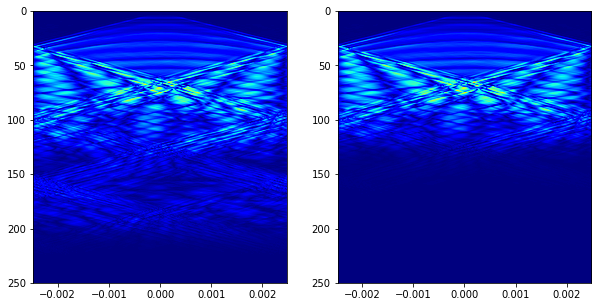

In [13]:
nr, nt = p.shape
dr, dt = 200, 0.002

nffts = (nr, nt)
FFTop = FFT2D(dims=[nr, nt], 
              nffts=nffts, sampling=[dr, dt])
P = FFTop*p.flatten()
P = P.reshape(nffts)
Pfilt = FFTop*pfilt.flatten()
Pfilt = Pfilt.reshape(nffts)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.fft.fftshift(np.abs(P[:, :nfft//2-1]), axes=0).T, cmap='jet', interpolation='sinc',
              extent = (-FFTop.f1[nffts[0]//2-1], FFTop.f1[nffts[0]//2-1], FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[0].axis('tight');
axs[1].imshow(np.fft.fftshift(np.abs(Pfilt[:, :nfft//2-1]), axes=0).T, cmap='jet', interpolation='sinc',
              extent = (-FFTop.f1[nffts[0]//2-1], FFTop.f1[nffts[0]//2-1], FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[1].axis('tight');

## Calibration

Let's take the 'zero-offset' trace and find a calibration filter that cancels the upgoing field around the direct wave

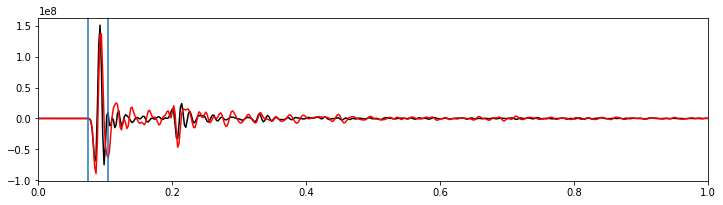

In [14]:
itrace = np.argmin(offset)
sc = 60
twin = 0.03

plt.figure(figsize=(12, 3))
plt.plot(t,pfilt[itrace], 'k')
plt.plot(t,-vzfilt[itrace] * sc, 'r')
plt.axvline(tdir[itrace])
plt.axvline(tdir[itrace]+twin)
plt.xlim(0, 1);

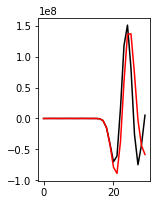

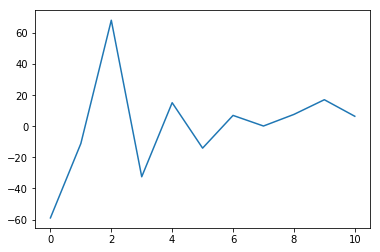

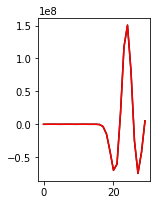

In [15]:
pwin = pfilt[itrace][int((tdir[itrace]-twin)/dt):int((tdir[itrace]+twin)/dt)]
vzwin = vzfilt[itrace][int((tdir[itrace]-twin)/dt):int((tdir[itrace]+twin)/dt)]
nwin = len(pwin)

plt.figure(figsize=(2, 3))
plt.plot(pwin, 'k')
plt.plot(-vzwin * sc, 'r')

nfilt = 11
VZ = convmtx(vzwin, nfilt)[:nwin]
h = np.linalg.lstsq(VZ, pwin)[0]
plt.figure()
plt.plot(h)

vzwincalib = sp.signal.fftconvolve(vzwin, h)[:nwin]
plt.figure(figsize=(2, 3))
plt.plot(pwin, 'k')
plt.plot(vzwincalib, 'r')

vzcalib = sp.signal.fftconvolve(vzfilt, h[np.newaxis, :], axes=-1)[:, :nt]

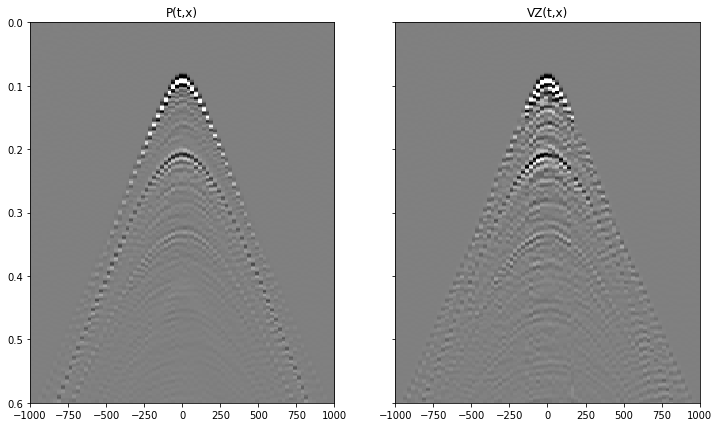

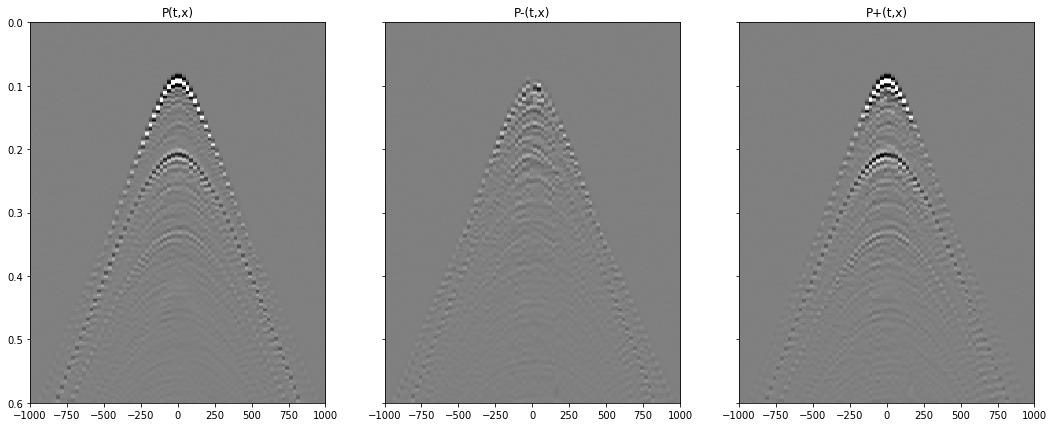

In [16]:
pup = (pfilt - vzcalib) / 2
pdown = (pfilt + vzcalib) / 2

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 7))
axs[0].imshow(pfilt.T, cmap='gray', vmin=-5e7, vmax=5e7,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[1].imshow(vzcalib.T, cmap='gray', vmin=-5e7, vmax=5e7,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].set_title('VZ(t,x)')
axs[1].axis('tight')
axs[1].set_ylim(.6, 0)
axs[1].set_xlim(-1000, 1000);

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 7))
axs[0].imshow(pfilt.T, cmap='gray', vmin=-5e7, vmax=5e7,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[1].imshow(pup.T, cmap='gray', vmin=-5e7, vmax=5e7,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].set_title('P-(t,x)')
axs[1].axis('tight')
axs[2].imshow(pdown.T, cmap='gray', vmin=-5e7, vmax=5e7,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[2].set_title('P+(t,x)')
axs[2].axis('tight')
axs[2].set_ylim(.6, 0)
axs[2].set_xlim(-1000, 1000);

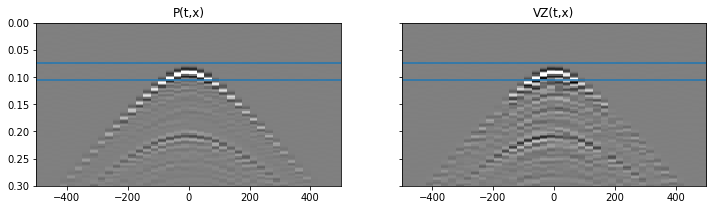

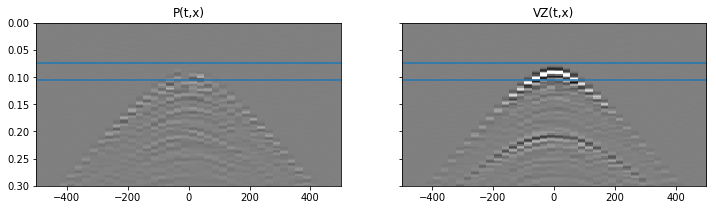

In [17]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 3))
axs[0].imshow(pfilt.T, cmap='gray', vmin=-1e8, vmax=1e8,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].axhline(tdir[nr//2])
axs[0].axhline(tdir[nr//2]+twin)
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[1].imshow(vzcalib.T, cmap='gray', vmin=-1e8, vmax=1e8,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].axhline(tdir[nr//2])
axs[1].axhline(tdir[nr//2]+twin)
axs[1].set_title('VZ(t,x)')
axs[1].axis('tight')
axs[1].set_ylim(.3, 0)
axs[0].set_xlim(-500, 500)
axs[1].set_xlim(-500, 500);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 3))
axs[0].imshow(pup.T, cmap='gray', vmin=-1e8, vmax=1e8,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[0].axhline(tdir[nr//2])
axs[0].axhline(tdir[nr//2]+twin)
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[1].imshow(pdown.T, cmap='gray', vmin=-1e8, vmax=1e8,
              extent = (-offset[0], offset[-1], t[-1], t[0]))
axs[1].axhline(tdir[nr//2])
axs[1].axhline(tdir[nr//2]+twin)
axs[1].set_title('VZ(t,x)')
axs[1].axis('tight')
axs[1].set_ylim(.3, 0)
axs[0].set_xlim(-500, 500)
axs[1].set_xlim(-500, 500);

Create frequency-wavenumber spectra (using PyLops FFT2D)

In [18]:
nfft=2**12
FFTop = FFT2D(dims=[nr, nt // 2], nffts=[nfft, nfft], sampling=[dr, dt])

P = FFTop * p[:, :nt//2].flatten()
VZ = FFTop * vz[:, :nt//2].flatten()
PUP = FFTop * pup[:, :nt//2].flatten()
PDOWN = FFTop * pdown[:, :nt//2].flatten()

P = P.reshape(nfft, nfft)
VZ = VZ.reshape(nfft, nfft)
PUP = PUP.reshape(nfft, nfft)
PDOWN = PDOWN.reshape(nfft, nfft)

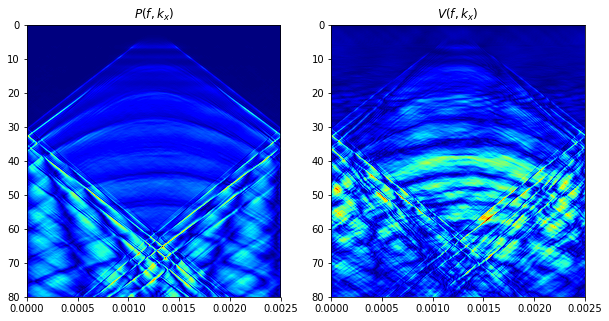

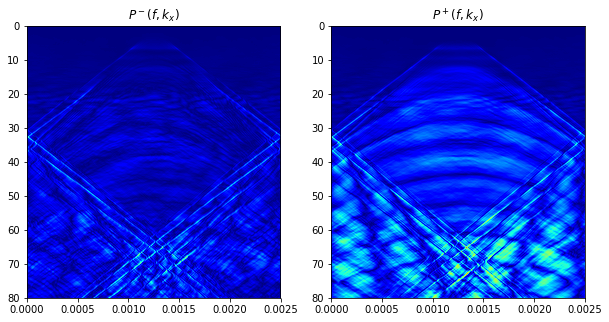

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(P[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(80, 0)
im=axs[1].imshow(np.fft.fftshift(np.abs(VZ[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(VZ).max())
axs[1].set_title(r'$V(f, k_x)$')
axs[1].axis('tight')
axs[1].set_ylim(80, 0)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^-(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(80, 0)
im=axs[1].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[1].set_title(r'$P^+(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(80, 0);

In [184]:
def calibrated_wavefield_separation(shot, plotflag=False):
    # read geometry for selected shot
    jshot=4 # not to get all components
    vwater = 1480.

    src_x = f.attributes(segyio.TraceField.SourceX)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]
    src_y = f.attributes(segyio.TraceField.SourceY)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]
    src_z = f.attributes(segyio.TraceField.SourceDepth)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]

    rec_x = f.attributes(segyio.TraceField.GroupX)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]
    rec_y = f.attributes(segyio.TraceField.GroupY)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]
    rec_z = f.attributes(segyio.TraceField.GroupWaterDepth)[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot:jshot]

    # compute offset
    offset = np.sqrt((src_x[0]/10. - rec_x/10.) ** 2 + (src_y[0]/10. - rec_y/10.) ** 2)
    distance = np.sqrt((src_z[0]/10. - rec_z/10.) ** 2 + (src_x[0]/10. - rec_x/10.) ** 2 + (src_y[0]/10. - rec_y/10.) ** 2)
    tdir = distance / vwater
    offsetreg = np.linspace(-offset[0], offset[-1], nr)
    
    # read data
    t = f.samples / 1000.
    dt = t[1]-t[0]

    d = segyio.collect(f.trace[shot*ntraces_per_shot:(shot+1)*ntraces_per_shot])
    p = d[::4]
    vz = d[1::4]
    vx = d[2::4]
    vy = d[3::4]

    # filter data to remove high-freq noise
    pfilt = butter_lowpass_filter(p, 110., 1/dt, 5)
    Pfilt = np.fft.fft(pfilt, n=nfft, axis=-1)

    vzfilt = butter_lowpass_filter(vz, 110., 1/dt, 5)
    VZfilt = np.fft.fft(vzfilt, n=nfft, axis=-1)

    itrace = np.argmin(offset)
    sc = 60
    twin = [0.01, 0.07]
    
    # extract window around direct arrival
    pwin = pfilt[itrace][int((tdir[itrace]-twin[0])/dt):int((tdir[itrace]+twin[1])/dt)]
    vzwin = vzfilt[itrace][int((tdir[itrace]-twin[0])/dt):int((tdir[itrace]+twin[1])/dt)]
    nwin = len(pwin)

    # perform calibration
    nfilt = 15
    VZ = convmtx(vzwin, nfilt)[:nwin]
    h = np.linalg.lstsq(VZ, pwin)[0]
    
    vzwincalib = sp.signal.fftconvolve(vzwin, h)[:nwin]
    vzcalib = sp.signal.fftconvolve(vzfilt, h[np.newaxis, :], axes=-1)[:, :nt]
    
    # perform separation
    pup = (pfilt - vzcalib) / 2
    pdown = (pfilt + vzcalib) / 2
    
    if plotflag:
        plt.figure(figsize=(2, 3))
        plt.plot(pwin, 'k')
        plt.plot(-vzwin * sc, 'r')
        
        plt.figure()
        plt.plot(h)
        plt.figure(figsize=(2, 3))
        plt.plot(pwin, 'k')
        plt.plot(vzwincalib, 'r')

        fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 7))
        axs[0].imshow(pfilt.T, cmap='gray', vmin=-5e7, vmax=5e7,
                      extent = (-offset[0], offset[-1], t[-1], t[0]))
        axs[0].set_title('P(t,x)')
        axs[0].axis('tight')
        axs[1].imshow(vzcalib.T, cmap='gray', vmin=-5e7, vmax=5e7,
                      extent = (-offset[0], offset[-1], t[-1], t[0]))
        axs[1].set_title('VZ(t,x)')
        axs[1].axis('tight')
        axs[1].set_ylim(.6, 0)
        axs[1].set_xlim(-1000, 1000);

        fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 7))
        axs[0].imshow(pfilt.T, cmap='gray', vmin=-5e7, vmax=5e7,
                      extent = (-offset[0], offset[-1], t[-1], t[0]))
        axs[0].set_title('P(t,x)')
        axs[0].axis('tight')
        axs[1].imshow(pup.T, cmap='gray', vmin=-5e7, vmax=5e7,
                      extent = (-offset[0], offset[-1], t[-1], t[0]))
        axs[1].set_title('P-(t,x)')
        axs[1].axis('tight')
        axs[2].imshow(pdown.T, cmap='gray', vmin=-5e7, vmax=5e7,
                      extent = (-offset[0], offset[-1], t[-1], t[0]))
        axs[2].set_title('P+(t,x)')
        axs[2].axis('tight')
        axs[2].set_ylim(.6, 0)
        axs[2].set_xlim(-1000, 1000)

    return pfilt, vzfilt, pup, pdown, pfilt[itrace], pup[itrace], pdown[itrace], rec_x[itrace], rec_y[itrace]

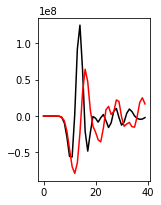

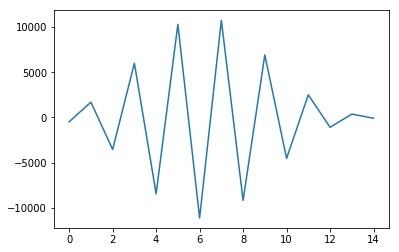

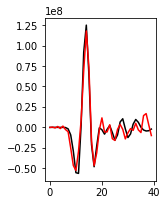

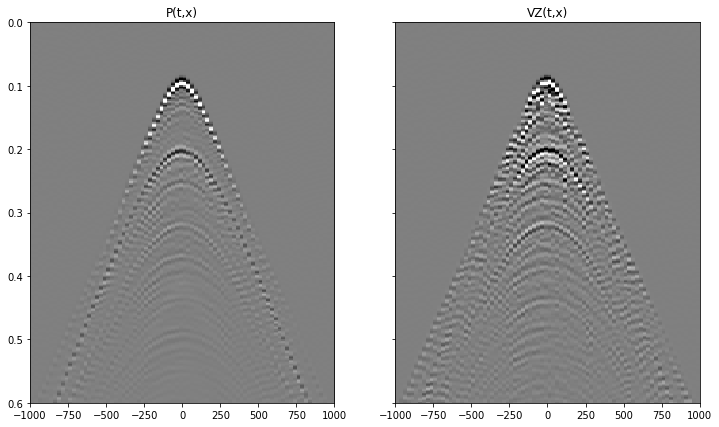

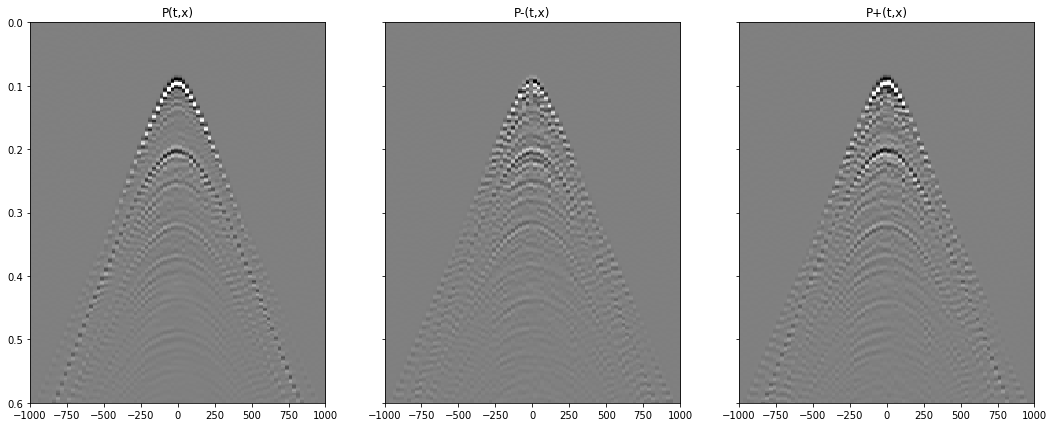

In [185]:
calibrated_wavefield_separation(4970, plotflag=True);

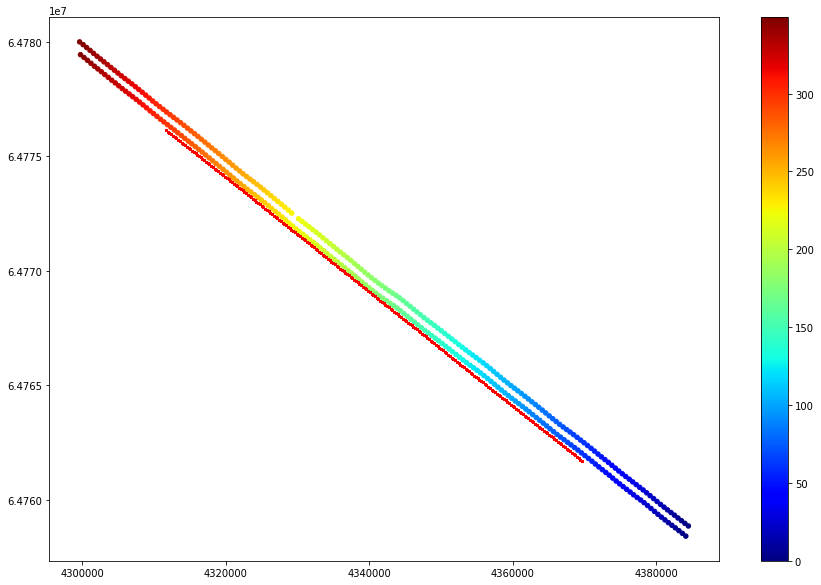

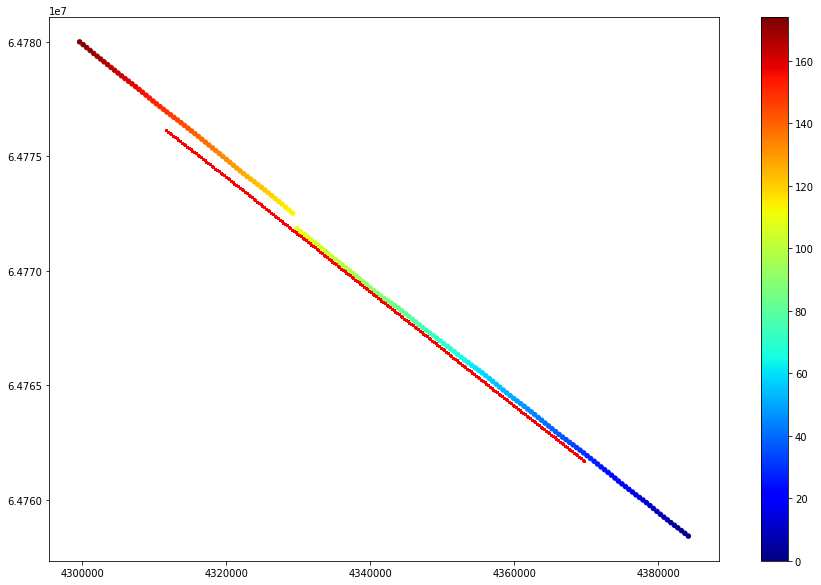

In [186]:
startshot=4850
endshot=5200
jshot= 4 # not to get all components

src_x = f.attributes(segyio.TraceField.SourceX)[startshot*ntraces_per_shot:endshot*ntraces_per_shot:jshot]
src_y = f.attributes(segyio.TraceField.SourceY)[startshot*ntraces_per_shot:endshot*ntraces_per_shot:jshot]

rec_x = f.attributes(segyio.TraceField.GroupX)[startshot*ntraces_per_shot:endshot*ntraces_per_shot:jshot]
rec_y = f.attributes(segyio.TraceField.GroupY)[startshot*ntraces_per_shot:endshot*ntraces_per_shot:jshot]

plt.figure(figsize=(15, 10))
im = plt.scatter(src_x[::nr], src_y[::nr], 
                 c=np.arange(len(src_x[::nr])), s=20, cmap='jet')
plt.scatter(rec_x, rec_y, color='r', s=1)
plt.colorbar(im);

plt.figure(figsize=(15, 10))
im = plt.scatter(src_x[::nr][1::2], src_y[::nr][1::2], 
                 c=np.arange(len(src_x[::nr][1::2])), s=20, cmap='jet')
plt.scatter(rec_x, rec_y, color='r', s=1)
plt.colorbar(im);

In [187]:
nshots = endshot - startshot

p_zo = np.zeros((nshots, nt))
pup_zo = np.zeros((nshots, nt))
pdown_zo = np.zeros((nshots, nt))
rec_x_zo = np.zeros(nshots)
rec_y_zo = np.zeros(nshots)

for i, shot in enumerate(range(startshot, endshot)):
    _, _, _, _, p_zo[i], pup_zo[i], pdown_zo[i], rec_x_zo[i], rec_y_zo[i] = \
        calibrated_wavefield_separation(shot, plotflag=False)

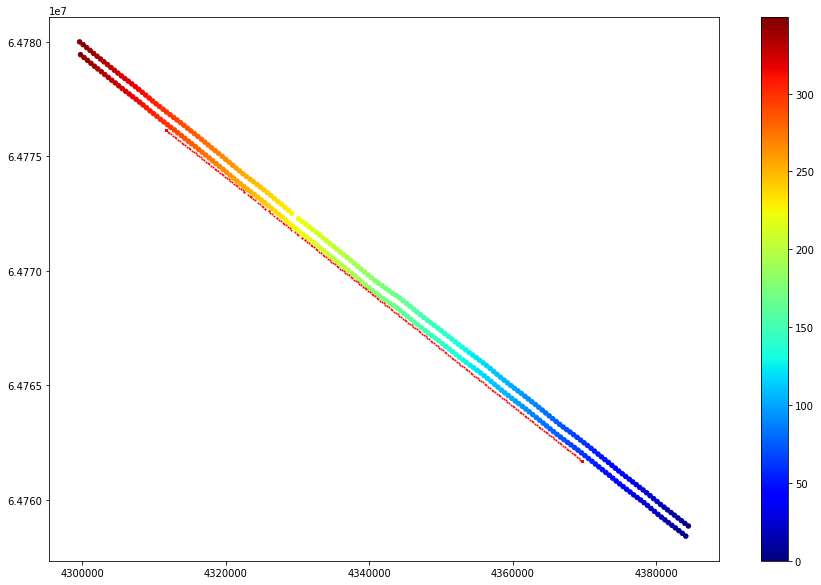

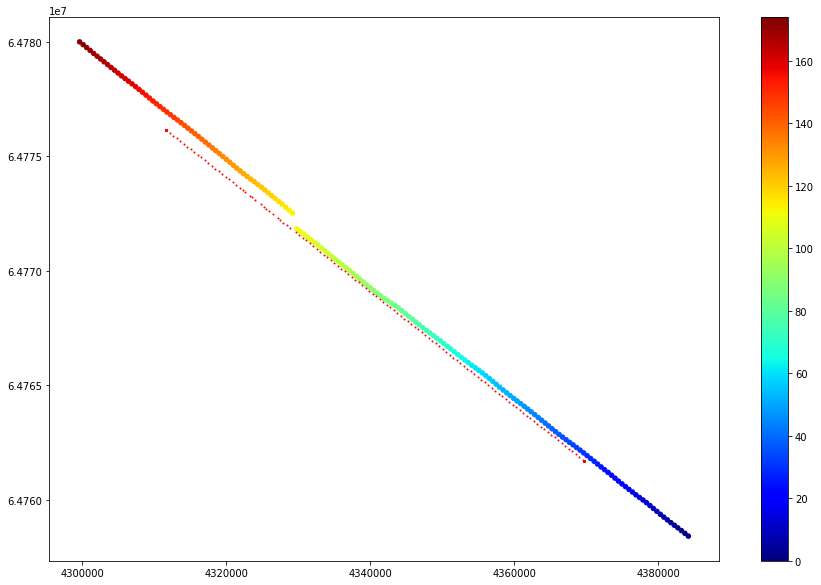

In [188]:
plt.figure(figsize=(15, 10))
im = plt.scatter(src_x[::nr], src_y[::nr], 
                 c=np.arange(len(src_x[::nr])), s=20, cmap='jet')
plt.scatter(rec_x_zo, rec_y_zo, color='r', s=1)
plt.colorbar(im);

plt.figure(figsize=(15, 10))
im = plt.scatter(src_x[::nr][1::2], src_y[::nr][1::2], 
                 c=np.arange(len(src_x[::nr][1::2])), s=20, cmap='jet')
plt.scatter(rec_x_zo[1::2], rec_y_zo[1::2], color='r', s=1)
plt.colorbar(im);

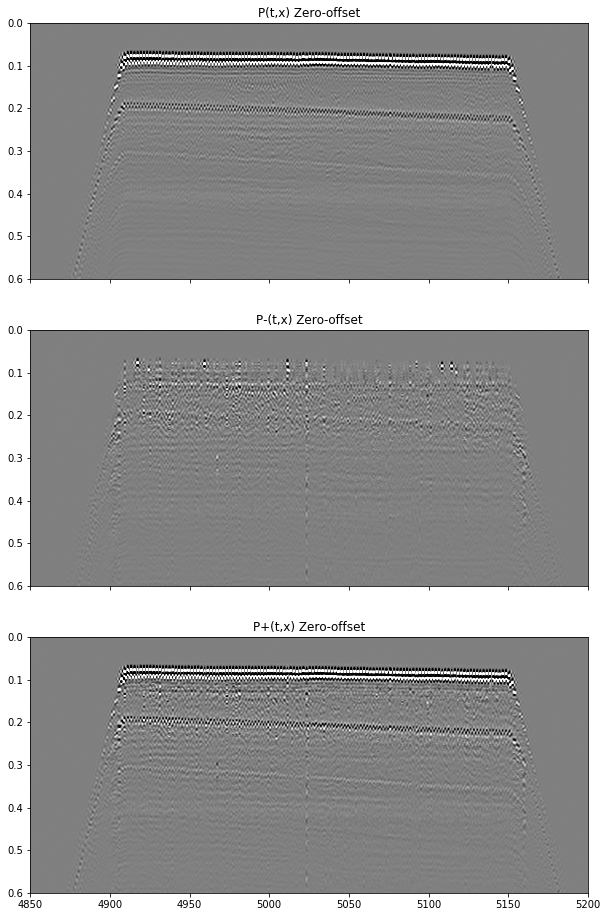

In [189]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 16))
axs[0].imshow(p_zo.T, cmap='gray', vmin=-5e7, vmax=5e7, interpolation='sinc',
             extent=(startshot, endshot, t[-1], t[0]))
axs[0].set_title('P(t,x) Zero-offset')
axs[0].axis('tight')
axs[1].imshow(pup_zo.T, cmap='gray', vmin=-5e7, vmax=5e7, interpolation='sinc',
             extent=(startshot, endshot, t[-1], t[0]))
axs[1].set_title('P-(t,x) Zero-offset')
axs[1].axis('tight')
axs[2].imshow(pdown_zo.T, cmap='gray', vmin=-5e7, vmax=5e7, interpolation='sinc',
             extent=(startshot, endshot, t[-1], t[0]))
axs[2].set_title('P+(t,x) Zero-offset')
axs[2].axis('tight')
axs[2].set_ylim(.6, 0.);

In [ ]:
tgain = np.sqrt(t)[:, np.newaxis]
#tgain = t[:, np.newaxis]**2

clip = 1e6
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 8))
axs[0].imshow(tgain * p_zo[1::2].T, cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, t[-1], t[0]))
axs[0].set_title('P(t,x) Zero-offset')
axs[0].axis('tight')
axs[1].imshow(tgain * pup_zo[1::2].T, cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, t[-1], t[0]))
axs[1].set_title('P-(t,x) Zero-offset')
axs[1].axis('tight')
axs[2].imshow(tgain * pdown_zo[1::2].T, cmap='gray', 
              vmin=-clip, vmax=clip, interpolation='sinc',
              extent=(startshot, endshot, t[-1], t[0]))
axs[2].set_title('P+(t,x) Zero-offset')
axs[2].axis('tight')
axs[2].set_ylim(2., 0.);